## Win/Loss Betting Model


In [6]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, bernoulli
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from spcl_case import *
plt.style.use('fivethirtyeight')

Obtain results of teams within the past year

In [7]:
h_matches = pd.read_csv('hltv_csv/matchResults.csv').set_index('Match ID')
h_matches['Date'] = pd.to_datetime(h_matches['Date'])
h_teams = pd.read_csv('hltv_csv/teams_w_ranking.csv')
h_teams = fix_teams(h_teams.set_index('ID'))
h_players = pd.read_csv('hltv_csv/matchLineups.csv').set_index('Match ID')
h_player_names = pd.read_csv('hltv_csv/players.csv').set_index('ID')

In [8]:
MIN_DATE = dt.datetime(2017,1,1)
EVENT_SET = 'eslpl'
FILTER_TEAMS = {'eslpl': ['OpTic', 'SK', 'Cloud9', 'Liquid', 'Luminosity', 'Misfits', 'Renegades', 'Immortals', 
                    'Splyce', 'compLexity', 'Rogue', 'Ghost', 'CLG', 'NRG', 'FaZe', 'North',
                    'BIG', 'LDLC', 'mousesports', 'EnVyUs', 'NiP', 'Virtus.pro', 
                    'Astralis', 'G2', 'GODSENT', 'Heroic', 'fnatic', 'NiP', 'Heroic'],
                'mdleu': ['Virtus.pro', 'FlipSid3', 'eXtatus', 'AGO', 'Fragsters', 'Gambit', 'PRIDE', '1337HUANIA', 
                    'VITALIS', 'Epsilon', 'CHAOS', 'Crowns', 'MK', 'Japaleno', 'Not Academy', 'aAa', 'Space Soldiers',
                    'Singularity', 'Nexus', 'Invictus Aquilas', 'Spirit', 'Kinguin', 'Seed', 'Endpoint', 'iGame.com', 'TEAM5',
                    'ALTERNATE aTTaX'],
                'mdlna': ['Gale Force', 'FRENCH CANADIANS', 'Mythic', 'GX', 'Beacon', 'Torqued', 'Rise Nation', 'Denial', 'subtLe', 
                   'SoaR', 'Muffin Lightning', 'Iceberg', 'ex-Nitrious', 'Adaptation', 'Morior Invictus', 'Naventic', 'CheckSix', 'Good People'
                   , 'LFAO', 'CLG Academy', 'Ambition', 'Mostly Harmless', 'Gorilla Core', 'ex-Nitrious', 'ANTI ECO'],
                'mdlau': ['Grayhound', 'Tainted Minds', 'Kings', 'Chiefs', 'Dark Sided', 'seadoggs', 'Athletico', 'Legacy',
                    'SIN', 'Noxide', 'Control', 'SYF', 'Corvidae', 'Funkd', 'Masterminds', 'Conspiracy', 'AVANT']
               }

h_matches = h_matches[h_matches['Date'] >= MIN_DATE]
h_filter_teams = h_teams[h_teams['Name'].isin(FILTER_TEAMS[EVENT_SET])]
h_matches = h_matches[h_matches['Team 1 ID'].isin(h_filter_teams.index) | h_matches['Team 2 ID'].isin(h_filter_teams.index)]
h_matches['winner'] = h_matches.apply(lambda x: x['Team 1 Score'] > x['Team 2 Score'], axis=1)
h_matches['score_diff'] = h_matches['Team 1 Score'] - h_matches['Team 2 Score']
h_matches = h_matches.join(h_players)

In [9]:
player_col_names = ['Team 1 Player 1', 'Team 1 Player 2', 'Team 1 Player 3', 'Team 1 Player 4', 'Team 1 Player 5',
                 'Team 2 Player 1', 'Team 2 Player 2', 'Team 2 Player 3', 'Team 2 Player 4', 'Team 2 Player 5',]
obs = h_matches[['Map',  'score_diff', 'winner'] + player_col_names]
obs = obs[obs.Map != 'Default']
obs.head()

,Map,score_diff,winner,Team 1 Player 1,Team 1 Player 2,Team 1 Player 3,Team 1 Player 4,Team 1 Player 5,Team 2 Player 1,Team 2 Player 2,Team 2 Player 3,Team 2 Player 4,Team 2 Player 5
Match ID,,,,,,,,,,,,,
2307282/kinguin-vs-ldlc-esea-premier-season-23-europe-finals,Cobblestone,14,True,7356,8323,973,8327,5388,9545,7982,8184,8302,7166
2307282/kinguin-vs-ldlc-esea-premier-season-23-europe-finals,Overpass,7,True,7356,8323,973,8327,5388,9545,7982,8184,8302,7166
2307285/rogue-vs-ldlc-esea-season-23-global-challenge,Overpass,-11,False,5287,2799,7834,1883,7964,7982,9545,8302,7166,8184
2307288/bravado-vs-ldlc-esea-season-23-global-challenge,Overpass,-12,False,7992,8448,7993,8711,8446,7982,7166,9545,8184,8302
2307290/tsm-vs-rogue-esea-season-23-global-challenge,Train,-12,False,9258,10394,6451,8517,1915,7964,2799,5287,1883,7834


In [11]:
players = np.sort(np.unique(np.concatenate(obs[player_col_names].values)))
maps = obs.Map.unique()
tmap = {v:k for k,v in dict(enumerate(players)).items()}
mmap = {v:k for k,v in dict(enumerate(maps)).items()}
n_players = len(players)
n_maps = len(maps)
print('Number of Players: %i ' % n_players)
print('Number of Matches: %i ' % len(h_matches))
print('Number of Maps: %i '% n_maps)

Number of Players: 1017 
Number of Matches: 4205 
Number of Maps: 8 


## Pymc Model

Determining Binary Win Loss: $wl_{m,i,j}$
$$
\omega, \tau, \sim HC(0.5) \\
R_{k} \sim N(0, \omega^2) \\
\tilde{\theta}_{m,k} \sim N(0,1) \\
R_{m,k} = R_{k} + \tau\tilde{\theta} \\
wl_{m,i,j} \sim B(p = \text{Sig}(R_{m,i}-R_{m,j})) \\
$$

and score difference: $sc_{m,i,j}$

$$
\alpha \sim Gamma(10,5) \\
\kappa_{m,i,j} = 32\text{Sig}(\alpha(R_{m,i}-R_{m,j}))-16 \\
\sigma_{m} \sim HC(0.5) \\
sc_{m,i,j} \sim N(\kappa, \sigma_{m}^2)
$$

In [12]:
import pymc3 as pm
import theano.tensor as tt

In [24]:
obs_map = obs['Map'].map(mmap).values
obs_team = obs[player_col_names].apply(lambda x: x.map(tmap).values, axis=1).values
obs_team_1 = obs_team[:, :5]
obs_team_2 = obs_team[:, 5:10]

with pm.Model() as rating_model:
    
    omega = pm.HalfCauchy('omega', 0.5)
    tau = pm.HalfCauchy('tau', 0.5)
    rating = pm.Normal('rating', 0, omega, shape=n_players)
    theta_tilde = pm.Normal('rate_t', mu=0, sd=1, shape=(n_maps, n_players))
    rating_map = pm.Deterministic('rating | map', rating + tau * theta_tilde).flatten()
    
    diff = tt.sum(rating_map[obs_map[:,np.newaxis]*n_players+obs_team_1], axis=1) - tt.sum(rating_map[obs_map[:,np.newaxis]*n_players+obs_team_2], axis=1)
    p = 0.5*tt.tanh(diff)+0.5
    alpha = 0.325
    kappa = 16*tt.tanh(alpha*diff)
    sigma = pm.HalfCauchy('sigma', 0.5)
    
    sc = pm.Normal('observed score diff', kappa, sigma, observed=obs['score_diff'])
    wl = pm.Bernoulli('observed wl', p=p, observed=obs['winner'].values)

In [25]:
with rating_model:
    trace = pm.sample(5000, n_init=20000, init='jitter+adapt_diag', nuts_kwargs={'target_accept': 0.90}, tune=1000) # tune=1000, nuts_kwargs={'target_accept': 0.95}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [23:07<00:00,  4.32it/s]


{' NiKo': [0.62748657460630475, 0.24192145225961456],
 ' Snax': [0.12667347301022591, 0.46315729083765278],
 ' Stewie2K': [0.26634315470289294, 0.40374363248854206],
 ' coldzera': [0.36751728098359415, 0.44774405041221804],
 ' felps': [0.43088946972534414, 0.27031033029134932],
 ' kioShiMa': [0.37199250718833216, 0.3191926001046097],
 ' pashaBiceps': [0.82441388509585689, 0.41019324316572364],
 ' seang@res': [0.026694085882740897, 0.35239796842107546]}

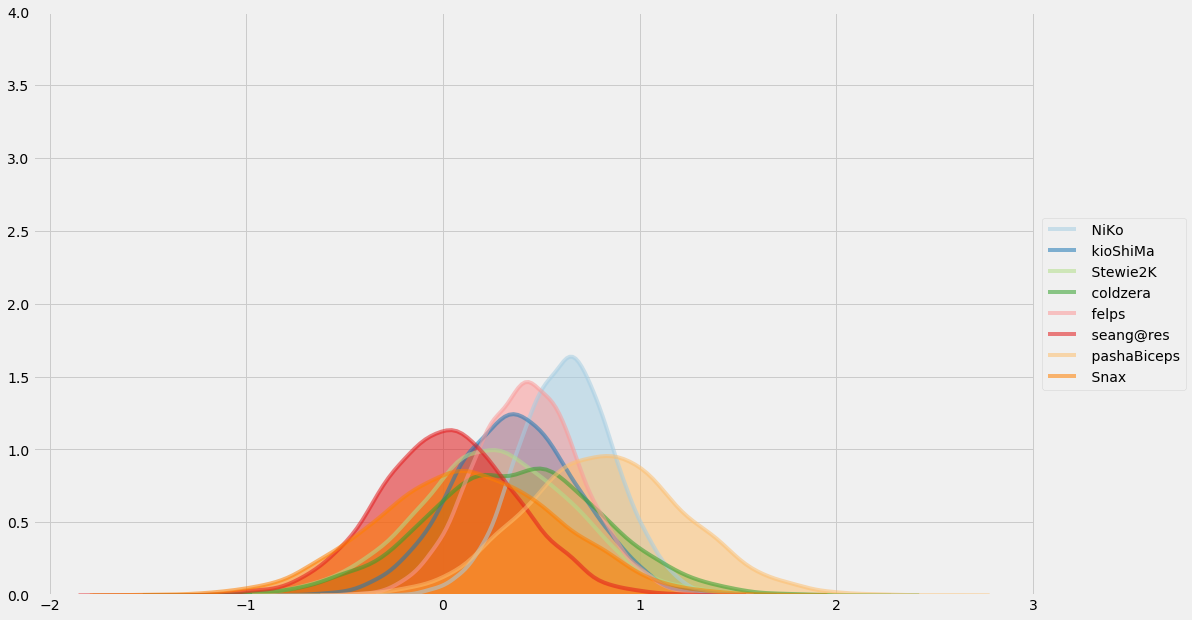

In [27]:
some_special_list = [3741, 4959, 8797, 9216, 9219, 1916, 317, 2553,]
filt = h_player_names.loc[some_special_list]
sns.set_palette('Paired', 10)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,4.0)
[sns.kdeplot(trace['rating'][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
{v['Name']: [trace['rating'][:,tmap[i]].mean(), trace['rating'][:,tmap[i]].std()] for i,v in filt.iterrows()}

# Save Model

In [28]:
EVENT_SET = 'player_eslpl'
pm.backends.text.dump('saved_model/'+EVENT_SET+'/trace', trace)
np.save('saved_model/'+EVENT_SET+'/players.npy', players)
np.save('saved_model/'+EVENT_SET+'/maps.npy', maps)

## Diagnostics

In [ ]:
with rating_model:
    approx = pm.fit(15000)
    ap_trace = approx.sample(5000)

In [ ]:
print('Gelman Rubin: %s' % pm.diagnostics.gelman_rubin(trace))
print('Effective N: %s' % pm.diagnostics.effective_n(trace))
print('Accept Prob: %.4f' % trace.get_sampler_stats('mean_tree_accept').mean())
print('Percentage of Divergent %.5f' % (trace['diverging'].nonzero()[0].size/float(len(trace))))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2895D02B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002A289332A20>]], dtype=object)

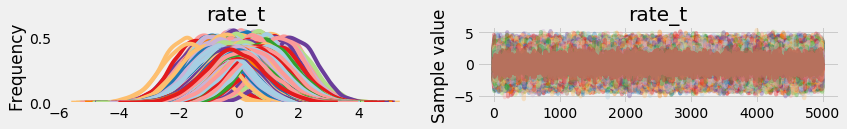

In [30]:
pm.traceplot(trace, varnames=['rate_t'])

In [23]:
trace['alpha'].mean()

0.32522305300079929

In [ ]:
rating_model.profile(pm.gradient(rating_model.logpt, rating_model.vars), n=100).summary()

In [ ]:
rating_model.profile(rating_model.logpt, n=100).summary()

## Moar Plots

In [ ]:
sns.set_palette('Paired', n_teams)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,2.0)
[sns.kdeplot(trace['sigma'][:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=m) for i,m in enumerate(maps)]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
f, axes = plt.subplots(n_maps,1,figsize=(12,34), sharex=True)
for m, ax in enumerate(axes):
    ax.set_title(dict(enumerate(maps))[m])
    ax.set_ylim(0,2.0)
    [sns.kdeplot(trace['rating | map'][:,m,tmap[i]], shade=True, alpha=0.55, legend=False ,
                 ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
filt

In [ ]:
i = np.where(teams==7880)
j = np.where(teams==7924)

diff = (trace['rating'][:,j] - trace['rating'][:,i]).flatten()
kappa = 32./(1+np.exp(-1.*trace['alpha']*diff))-16.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
sns.kdeplot(kappa, ax=ax2)
sns.kdeplot(diff, ax=ax1)

## Non-MCMC Model

In [ ]:
def vec2dict(s, n_teams):
    return {
        'mu': np.array(s[:n_teams]),
        'sigma': np.array(s[n_teams:n_teams*2]),
        'beta': s[-1],
    }

def dict2vec(s):
    return s['mu'] + s['sigma'] + [s['beta']]

In [ ]:
skills_0 = dict2vec({
    'mu': [1000]*n_teams,
    'sigma': [300]*n_teams,
    'beta': 50
})

In [ ]:
from scipy.optimize import minimize


def loglike(y,p):
    return -1.*(np.sum(y*np.log(p)+(1-y)*np.log(1.-p)))

def obj(skills):
    s = vec2dict(skills, n_teams)
    mean_diff = s['mu'][obs['Team 1 ID'].map(tmap).values] - s['mu'][obs['Team 2 ID'].map(tmap).values]
    var_diff = s['sigma'][obs['Team 1 ID'].map(tmap).values]**2 + s['sigma'][obs['Team 2 ID'].map(tmap).values]**2 + skills[-1]**2
    p = 1.-norm.cdf(0., loc=mean_diff, scale = np.sqrt(var_diff))
    return loglike((obs['Team 1 ID'] == obs['winner']).values, p)


In [ ]:
obj(skills_0)

In [ ]:
opt_skill = g.x
print(opt_skill)
plots = norm.rvs(opt_skill[:5], opt_skill[5:-1], size=(2000,5))

f, ax = plt.subplots(figsize=(12,8))
[sns.kdeplot(plots[:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in range(5)]